In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl

import copy


import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import pyTMD
import numpy as np
        
import pyTMD.io
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import timescale.time

np.float_ = np.float64
import dascore as dc

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


    fs = attrs['PulseRate'] #sample rate
    bp_top = 200
    bp_bottom = 1
    downsample_rate = int(fs/bp_top)

    #filter by freq
    sos = signal.butter(10, [bp_bottom,bp_top], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)

    #FK filter
    new_format_times = time_fixer_4_fk(times)
    dims = ('time', 'distance')
    patch = dc.Patch(data=filtered, coords=dict(time=[np.datetime64(i) for i in new_format_times], distance=x), dims=dims)
    filt_cutoffs = np.array([0, 400, 8000, np.inf])

    fk_filtered = patch.slope_filter(filt=filt_cutoffs)
    fk_filtered_data = np.array(fk_filtered.data)


    #normalize
    data_normed_filtered = chan_norm(fk_filtered_data)

    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)
    # print(filled_data.shape)
    # print(first_filler.shape)
    filled_data = np.zeros((int(fs*60),data_normed_filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)




    if data_locator[0]==0:
        filled_data[data_locator] = data_normed_filtered

    else:
        first_filler = np.array([data_normed_filtered[:,0]]*data_locator[0])
        filled_data[:first_filler.shape[0],:] = first_filler
    
    filt_filled_data = filled_data

    filled_times[data_locator] = times
    # filled_data[data_locator] = data_normed_filtered.T

    # filt_filled_data = filled_data

    ## Downsample 
    filled_times = filled_times[::downsample_rate]
    filt_filled_data = filt_filled_data[::downsample_rate,::5] #Skip every 5th channel
    new_dict = dict(attrs)
    new_dict['PulseRate'] = new_dict['PulseRate']/downsample_rate


    return filt_filled_data, filled_times, new_dict

def foo(a):
    t = mdates.num2date(a)
    ms = str(t.microsecond)[:1]
    res = f"{t.hour:02}:{t.minute:02}:{t.second:02}.{ms}"
    return res

def chan_norm(das_data):
    data_normed = (das_data - np.mean(das_data, axis=0))/np.std(das_data, axis=0).T
    # data_normed_all_axis = (data_normed.T - np.mean(data_normed, axis=1))/np.std(data_normed, axis=1)   

    return data_normed

class DataStats:
    def __init__(self, data, attrs, times):
        self.sampling_rate = attrs["PulseRate"]
        self.npts = data.shape[0]
        self.starttime = times[0]
        # self.starttime.isoformat

class DAS:
    def __init__(self, id, data, attrs, times):
        self.id = id
        self.data = data
        self.stats = DataStats(data, attrs, times)


def obspy_stream_from_das(data, attrs,times):
    stats_default = {
        'network':'eastwind',
        'station':'',
        'location':'',
        'channel':'DAS',
        'starttime':times[0].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'endtime':times[-1].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'sampling_rate':attrs['PulseRate'],
        'delta':1/attrs['PulseRate'],
        'npts':0,
        'calib':1.0
    }

    streams = []
    for n,i in enumerate(data.T):
        tr = obspy.Trace(data=i,header=stats_default)
        # tr.stats.station = f'Channel {n}'
        tr.stats.npts = len(i)

        st = obspy.Stream(tr)
        streams.append(st)
    return streams

def parallel_event_finding(dummy):
    times_all,attrs,channel,all_data = dummy
    trigger_on=3.5, 
    trigger_off=1.2
    
    DAS_channel = DAS(channel, all_data, attrs, times_all)


    cft = recursive_sta_lta(DAS_channel.data, int(1 * attrs['PulseRate']), int(10 * attrs['PulseRate']))
    trigger_times = trigger_onset(cft, trigger_on, trigger_off)
    trigger_times_list = [trigger_times]     

    trigger_times_list_datetime = []

    for trigs_samp_time in trigger_times_list:
        trigger_times_list_datetime.append(times_all[trigs_samp_time])
    return {str(channel): trigger_times_list_datetime}


def time_fixer_4_fk(times):
    times_copy = times.copy()
    new_format_times = []
    for i in times_copy:
        if round(i.microsecond/500)*500 == 1000000:
            microsecond = 0
            second = i.second + 1
            minute = i.minute
            hour = i.hour
            day = i.day
            if second == 60:
                second = 0
                minute = minute+1

            if minute == 60:
                minute = 0
                hour=hour+1
            
            if hour == 24:
                hour = 0
                day = day+1
            
        else:
            microsecond = int(round(i.microsecond/500)*500)
            second = i.second
            minute = i.minute
            hour = i.hour
            day = i.day

        new_format_times.append(datetime.datetime(year=i.year,
                                                month=i.month,
                                                day=day,
                                                hour=hour,
                                                minute=minute,
                                                second=second,
                                                microsecond=microsecond))
    return new_format_times


import pathlib



import pandas as pd
from obspy import UTCDateTime
from obspy.clients.fdsn.mass_downloader import (
    GlobalDomain,
    Restrictions,
    MassDownloader,
)
from obspy.core import AttribDict
from pyproj import Proj
from multiprocessing import Pool

from quakemigrate import QuakeScan, Trigger
from quakemigrate.io import Archive, read_stations
from quakemigrate.lut import compute_traveltimes
from quakemigrate.signal.onsets import STALTAOnset
from quakemigrate.signal.pickers import GaussianPicker
%matplotlib widget

In [2]:
with open('../auto_picked_events_all_chans_fk_filtered.pkl', 'rb') as file:
    picks = pkl.load(file)

picks = picks[:int(len(picks))] # We skipped every 5th channel


all_trigs_flat_no_duplicates = []

for i in picks:
    all_trigs_flat_no_duplicates.append([i[0]])
for chan in range(len(picks)):
    chan_picks = picks[chan]
    for k in range(1,len(chan_picks), 1):

        try:
            diff = chan_picks[k] - chan_picks[k-1]
            if diff < datetime.timedelta(seconds=0.01):
                # print('duplicate')
                continue

            else:
                all_trigs_flat_no_duplicates[chan].append(chan_picks[k])
        except:
            continue

# Clustering

In [ ]:
x_s = []
y_s = []
original_datetimes = []
for n,i in enumerate(all_trigs_flat_no_duplicates):

    x_i = [n]*len(i)

    x_s += x_i

    y_s += [q.timestamp() for q in i]

    original_datetimes += i

In [11]:
from scipy.stats import gaussian_kde
y_s_scaled = ((y_s-np.min(y_s)) / (np.max(y_s)-np.min(y_s)))**3
stuff = np.vstack([x_s, y_s])
z = gaussian_kde(stuff)(stuff)

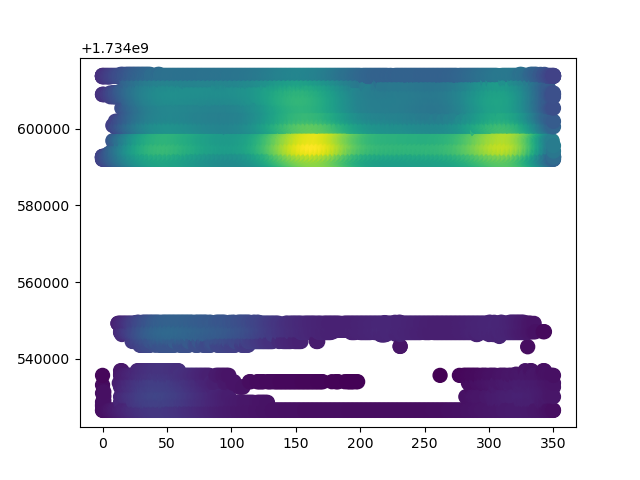

In [12]:
fig, ax = plt.subplots()
ax.scatter(x_s, y_s, c=z, s=100)
plt.show()

In [18]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

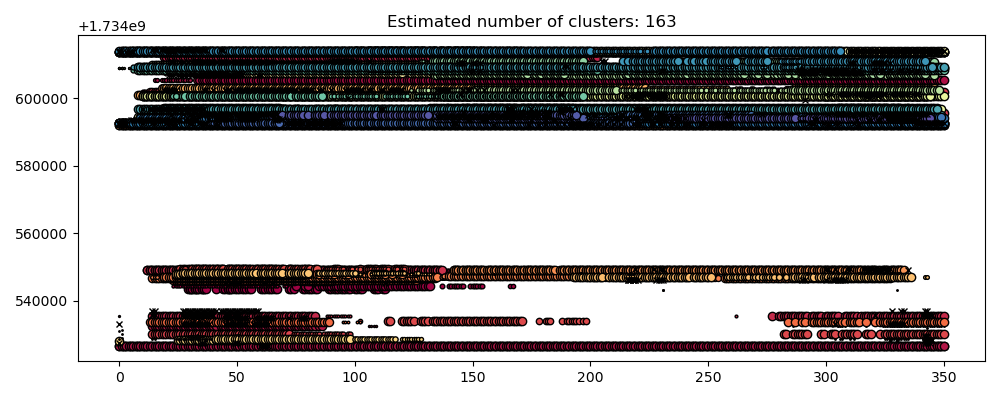

In [22]:

from sklearn import metrics
from sklearn.cluster import HDBSCAN
X = stuff.T

param = {"min_cluster_size": 50, "min_samples": 1}
hdb = HDBSCAN(copy=True, **param).fit(X)

plot(X, hdb.labels_, hdb.probabilities_)

In [197]:

from sklearn import metrics
from sklearn.cluster import DBSCAN
X = stuff.T
space_threshold=10
time_threshold_seconds = 1e0
db = DBSCAN(eps=max(space_threshold, time_threshold_seconds),min_samples=10, metric='euclidean').fit(X)

In [198]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 120
Estimated number of noise points: 376


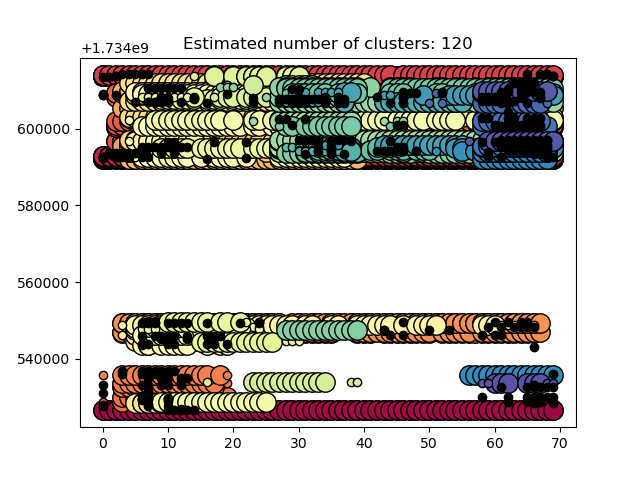

In [211]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure()
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [200]:
# Extract labels
labels = db.labels_

# Remove noise points (-1 label)
clustered_data = X[labels != -1]
clustered_times = np.array(original_datetimes)[labels != -1]  # Keep corresponding original datetime values

In [201]:
# Group detections by event
event_dict = {}
for (dist, dt), label in zip(X, labels):
    if label == -1:
        continue  # Ignore noise (isolated detections)
    if label not in event_dict:
        event_dict[label] = []
    event_dict[label].append((dist, dt))

# Convert to list format
grouped_events = list(event_dict.values())

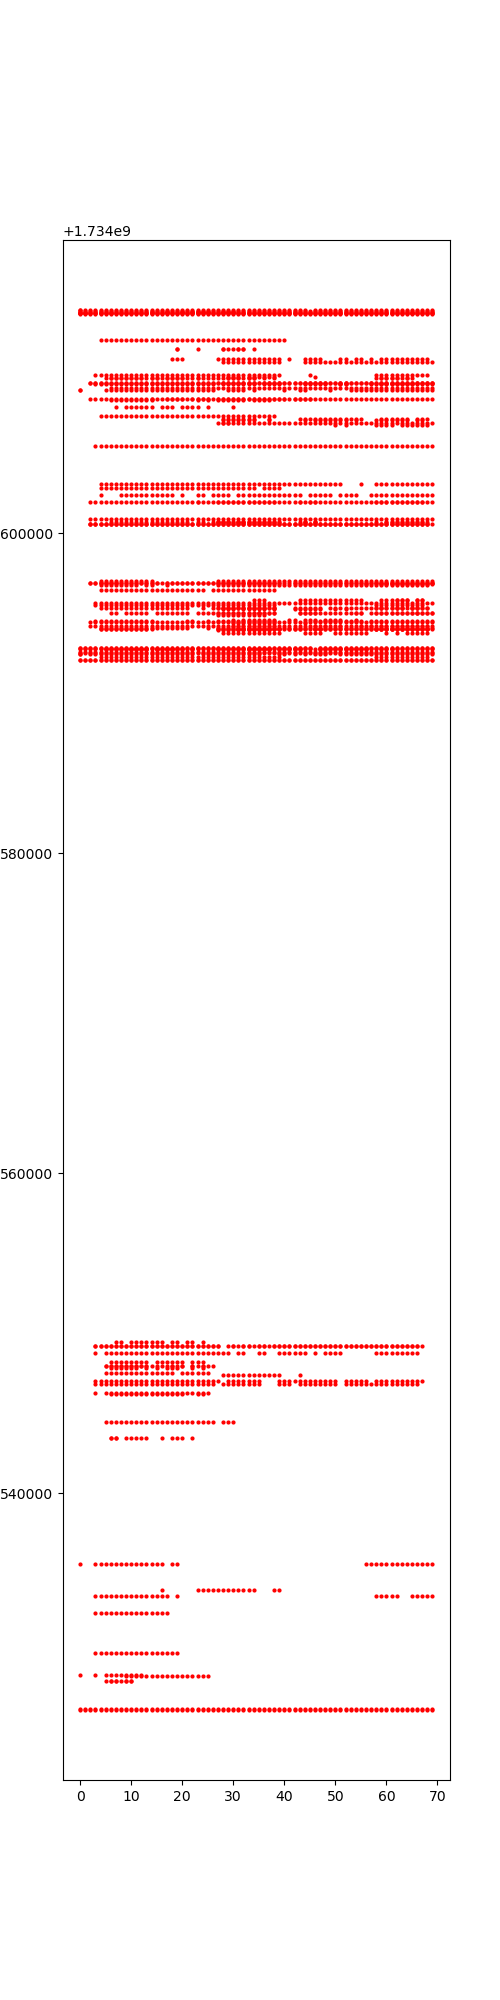

In [202]:
fig,ax = plt.subplots(figsize=(5,20))
for i, event in enumerate(grouped_events):
    # print(f"Event {i+1}: {event}")
    cable_pos = np.asarray(event)[:,0]
    event_time = np.asarray(event)[:,1]
    ax.scatter(cable_pos, event_time, c = 'red', s = 4)

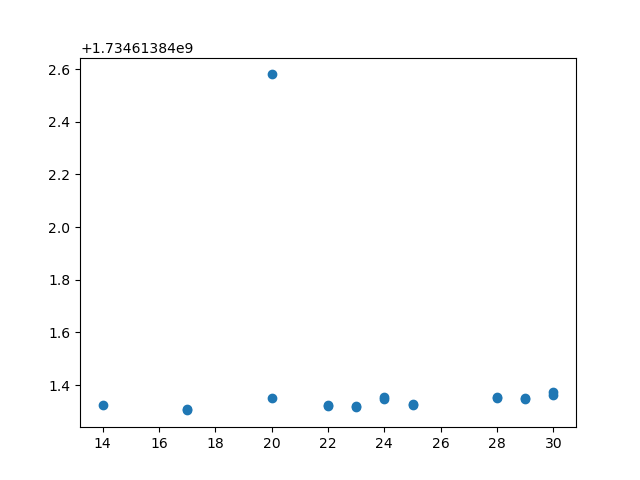

In [207]:
fig, ax = plt.subplots()

event_number = 73
ax.scatter(np.array(grouped_events[event_number])[:,0],np.array(grouped_events[event_number])[:,1])

Estimated number of clusters: 0
Estimated number of noise points: 70
Estimated number of clusters: 0
Estimated number of noise points: 70
Estimated number of clusters: 0
Estimated number of noise points: 10
Estimated number of clusters: 0
Estimated number of noise points: 17
Estimated number of clusters: 0
Estimated number of noise points: 70
Estimated number of clusters: 0
Estimated number of noise points: 70


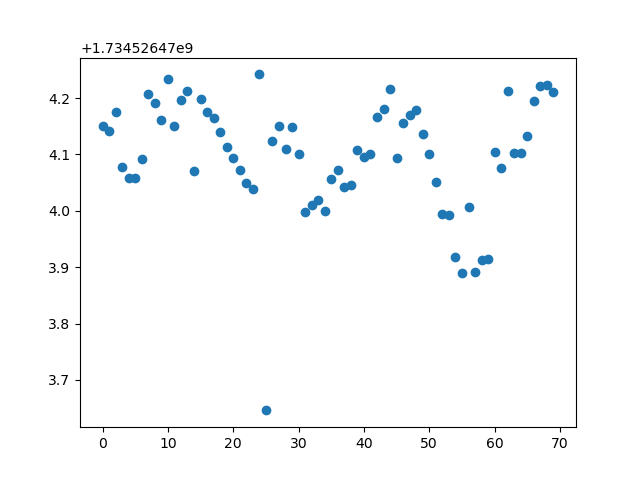

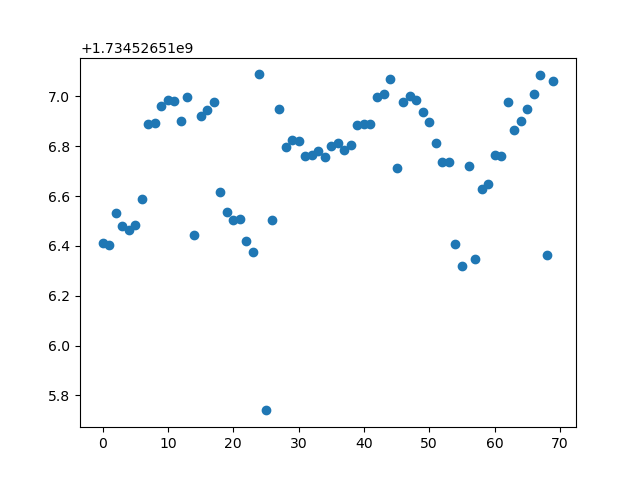

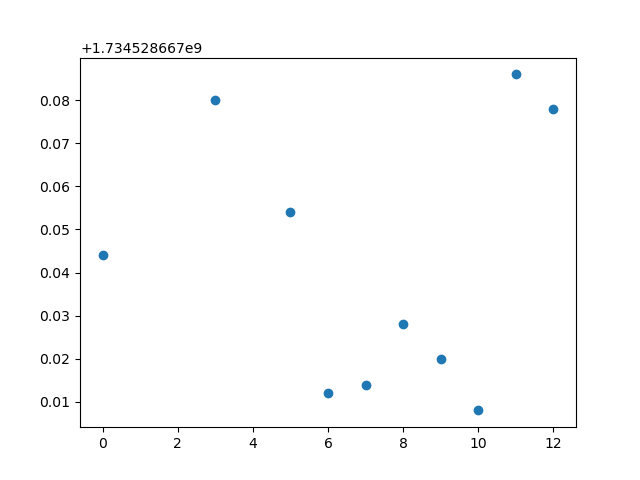

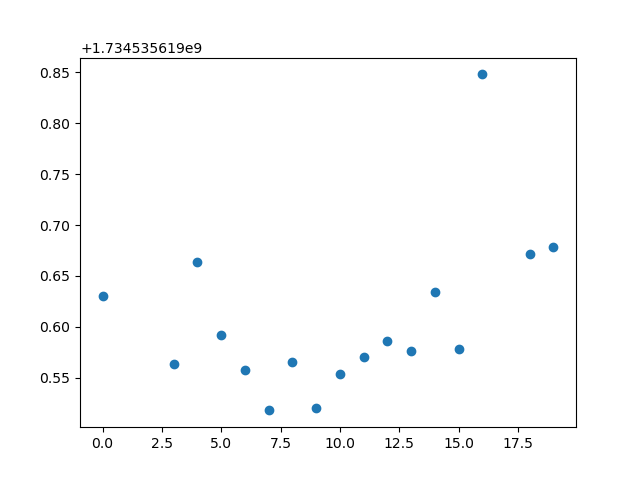

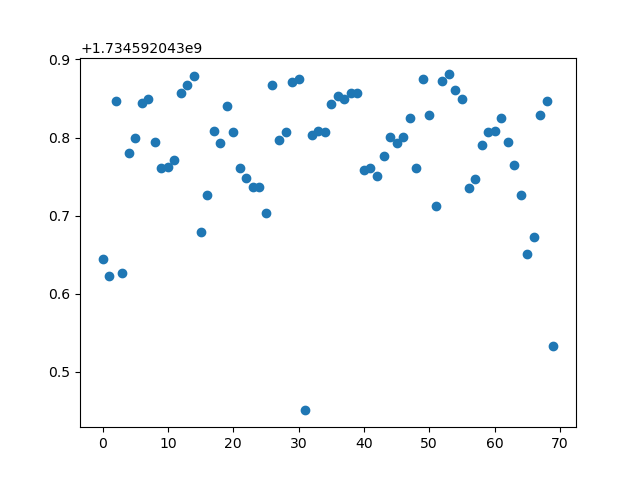

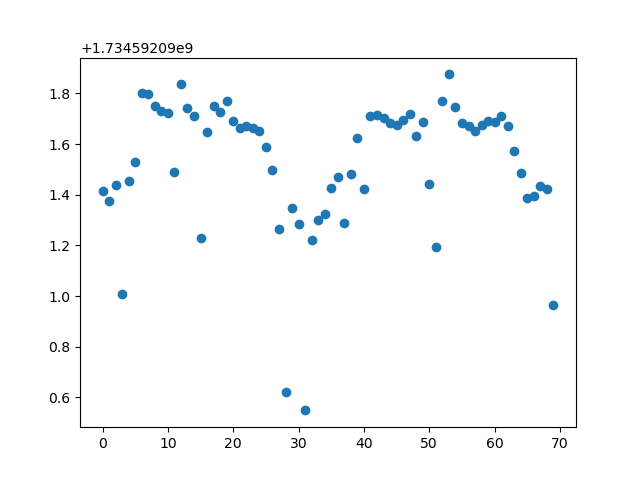

In [215]:
for n, i in enumerate(grouped_events):
    detection = np.array(i)
    stuff = np.vstack([detection[:,0], detection[:,1]])
    X = stuff.T
    
    space_threshold=10
    time_threshold_seconds = 1e0
    db = DBSCAN(eps=max(space_threshold, time_threshold_seconds),min_samples=20, metric='euclidean').fit(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    fig,ax = plt.subplots()
    ax.plot(detection[:,0], detection[:,1], "o", markersize=6)
    if n == 5: break

# Can we pick events by like a histogram and/or peak finding?

In [32]:
x_s = []
y_s = []
original_datetimes = []
for n,i in enumerate(all_trigs_flat_no_duplicates):

    x_i = [n]*len(i)

    x_s += x_i

    y_s += [q.timestamp() for q in i]

    original_datetimes += i

In [ ]:
density = scipy.stats.gaussian_kde(sorted(y_s))

In [77]:
density.covariance_factor = lambda : .0001
density._compute_covariance()

In [101]:
y_res = np.linspace(np.min(y_s), np.max(y_s), 150000)
y_dense = density(y_res)

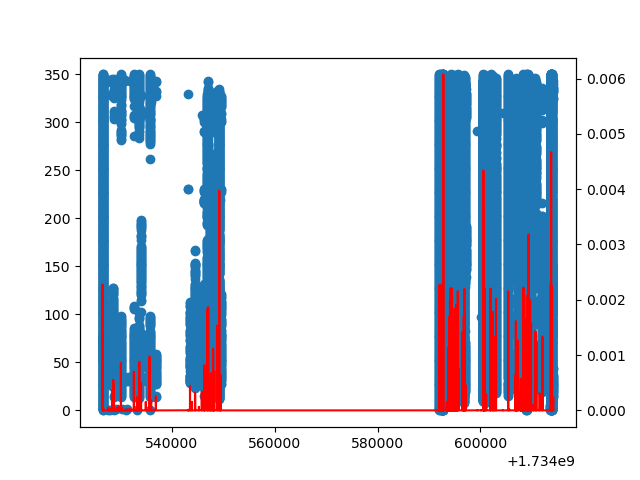

In [102]:
fig, ax = plt.subplots()
ax.scatter(y_s, x_s)


ax2 = ax.twinx()
ax2.plot(y_res,y_dense, c='red')

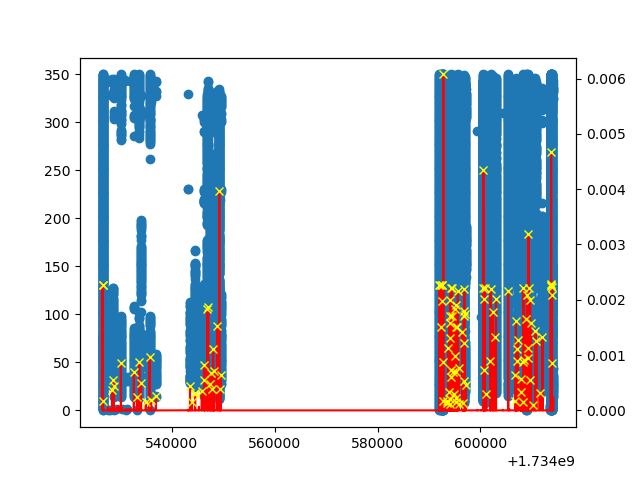

In [128]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(y_dense, height=1e-4)

fig, ax = plt.subplots()
ax.scatter(y_s, x_s)


ax2 = ax.twinx()
ax2.plot(y_res,y_dense, c='red')

ax2.plot(y_res[peaks],y_dense[peaks], "x", c='yellow')



### Now group

In [170]:
grouped_events_v2 = {}
event_number_counter = 0
for num, event in enumerate(y_res[peaks]):
    event_group_times = []
    event_group_chans = []
    for chan,trig in zip(x_s,y_s):
        if event-.5 < trig < event+.5:

            event_group_times.append(trig)
            event_group_chans.append(chan)
    if len(event_group_times) > 50:
        grouped_events_v2['Event '+str(event_number_counter)] = [event_group_chans, event_group_times]
        event_number_counter += 1

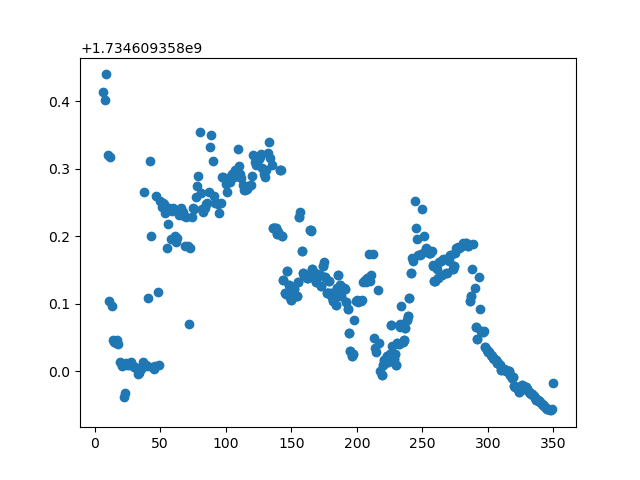

In [196]:
event_of_interest = 84
chans_interest = grouped_events_v2['Event '+str(event_of_interest)][0]
times_interest = grouped_events_v2['Event '+str(event_of_interest)][1]


fig,ax = plt.subplots()

ax.scatter(chans_interest, times_interest)

In [198]:
# with open('../auto_picked_events/auto_picked_events.pkl', 'wb') as file:
#     # Serialize and write the data to the file
#     pkl.dump(grouped_events_v2, file)